In [3]:
!pip install torchsummary

In [2]:
!pip install torchviz


     |████████████████████████████████| 46 kB 764 kB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4149 sha256=1ddc2504fd90484d201ea6de41bfcf69aa5bf42119e97865b1cebcd2ed64011b
  Stored in directory: /home/gauri/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [6]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import datetime
import convLSTM_interpolation
from torchsummary import summary
from torchviz import make_dot

hr_start, hr_end = 0, 1440
n_servers = 3
epsilon = 1e-9
test_fraction = 1/20
valid_fraction = 0
# important hyperparameters for normal training
n_epochs = 12000
hidden_dim = 8

n_lat_grid_lines = 100
n_long_grid_lines = 100
grid_size = 100   # hardcoded, please don't modify
optimizer = "Adam"
features = ['pm1_0']#,'temperature','pressure','humidity']
time_gap = 120
time_steps = (hr_end-hr_start)//time_gap+1
batch_size = 1
real_aqi = 'aqi'
learning_rate = 1e-2
# sliding window hyperparameters
window_size = 5
threshold = 0.5
count_threshold = int(threshold*(window_size*window_size))
test_count = 2
step = 1
window_epochs = 40
window_count = 0
window_method = False

df = pd.read_csv('20-10_all.csv')

columns = ['lat','long','pm1_0','pm2_5','pm10','pressure','temperature','humidity']


In [7]:
# typecasting
for column in columns[2:]:
    df[column] = df[column].astype(float)
df.dateTime = pd.to_datetime(df.dateTime)

# removing anomalies
df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
df = df[(df.humidity<=60)&(df.humidity>=7)]

print(len(df))

# rounding @5min
df.dateTime = df.dateTime.dt.round(f'{time_gap}min')

# filter time
df = df[(df['dateTime'].dt.day == 20)]
df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
print(f"Before filter : {len(df)}")
df = df[(df.dateTime>=hr_start) & (df.dateTime<=hr_end)]
print(f"After filter : {len(df)}")
df.dateTime -= hr_start
df

86892
Before filter : 83166
After filter : 83166


,Unnamed: 0,dateTime,deviceId,uid,pm1_0,pm2_5,pm10,lat,long,pressure,temperature,humidity
0,0,0,00000000078e6811,79a66147-d42f-438c-ada4-b872ba473e2c,79.0,126.0,141.0,28.547970,77.276649,982.329219,33.10,25.739258
1,1,0,0000000024568afd,3b9159da-f4a6-4576-a2b9-b973f61f9cce,79.0,124.0,133.0,28.562967,77.250458,981.809687,31.70,26.247070
2,2,0,00000000980cc94b,7f7f9899-b0da-466a-98ef-815ac942ecb7,82.0,131.0,147.0,28.579346,77.231483,983.689062,28.03,35.611328
3,3,0,00000000812d59d2,dc9e628f-00e8-4b01-913a-1895542dbdbb,77.0,125.0,133.0,28.579374,77.230804,980.423125,23.40,46.635742
4,4,0,00000000078e6811,0076dadc-09ff-455c-adf3-97116261faeb,77.0,125.0,137.0,28.548201,77.276474,982.376562,33.10,25.729492
...,...,...,...,...,...,...,...,...,...,...,...,...
93422,93422,1320,0000000024568afd,c622c0b1-0eca-4edc-81fb-f718f642e8b9,75.0,115.0,126.0,28.579395,77.226433,984.561875,32.43,35.084961
93423,93423,1320,0000000038861c77,401ee8c6-045d-4c7d-a12f-baefcf2d03e8,77.0,120.0,129.0,28.579184,77.228294,980.312812,32.98,36.231445
93424,93424,1320,0000000038861c77,f2e6b94d-1051-4917-b4ed-b1317a78ec0b,77.0,123.0,131.0,28.579180,77.228294,980.363672,32.98,36.231445
93425,93425,1320,00000000078e6811,6c15644f-8312-4c50-9b8f-eddf16204479,73.0,115.0,132.0,28.579447,77.225449,985.204922,31.80,34.610352


In [8]:
# perform min max normalization
def min_max_normalize(column):
    df[column] = (df[column]-df[column].min())/(df[column].max() - df[column].min())

df[real_aqi] = df['pm1_0']*1.0

for column in columns:
    min_max_normalize(column)

for column in columns[:2]:
    df[column] = (df[column]*(grid_size-1)).astype(int)

# for servers, we would create n_server grids of size (4,h,w) and merge them
# 4 : (pm1_0, temperature, pressure, humidity)
# these servers would contain individual data which would be combined through crypten/MPC

df['server'] = np.random.randint(0,n_servers,len(df))

In [9]:
df

,Unnamed: 0,dateTime,deviceId,uid,pm1_0,pm2_5,pm10,lat,long,pressure,temperature,humidity,aqi,server
0,0,0,00000000078e6811,79a66147-d42f-438c-ada4-b872ba473e2c,0.144963,0.088643,0.081259,30,82,0.441335,0.401454,0.370456,79.0,0
1,1,0,0000000024568afd,3b9159da-f4a6-4576-a2b9-b973f61f9cce,0.144963,0.086796,0.075403,38,68,0.425719,0.347876,0.380775,79.0,0
2,2,0,00000000980cc94b,7f7f9899-b0da-466a-98ef-815ac942ecb7,0.152334,0.093259,0.085652,47,58,0.482210,0.207424,0.571063,82.0,2
3,3,0,00000000812d59d2,dc9e628f-00e8-4b01-913a-1895542dbdbb,0.140049,0.087719,0.075403,47,57,0.384040,0.030233,0.795087,77.0,2
4,4,0,00000000078e6811,0076dadc-09ff-455c-adf3-97116261faeb,0.140049,0.087719,0.078331,31,82,0.442758,0.401454,0.370257,77.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93422,93422,1320,0000000024568afd,c622c0b1-0eca-4edc-81fb-f718f642e8b9,0.135135,0.078486,0.070278,47,55,0.508446,0.375813,0.560367,75.0,1
93423,93423,1320,0000000038861c77,401ee8c6-045d-4c7d-a12f-baefcf2d03e8,0.140049,0.083102,0.072474,47,56,0.380724,0.396862,0.583664,77.0,0
93424,93424,1320,0000000038861c77,f2e6b94d-1051-4917-b4ed-b1317a78ec0b,0.140049,0.085873,0.073939,47,56,0.382253,0.396862,0.583664,77.0,0
93425,93425,1320,00000000078e6811,6c15644f-8312-4c50-9b8f-eddf16204479,0.130221,0.078486,0.074671,47,54,0.527775,0.351703,0.550722,73.0,2


In [10]:
server_grids = [torch.zeros(batch_size,time_steps,len(features),grid_size,grid_size,dtype=torch.float32) for _ in range(n_servers)]   # (b,t,c,h,w)
server_grid_count = [torch.zeros(time_steps,grid_size,grid_size,dtype=torch.int64) for _ in range(n_servers)]

server_aqi_grids = [torch.zeros(batch_size,time_steps,1,grid_size,grid_size,dtype=torch.float32) for _ in range(n_servers)]   # (b,t,c,h,w)

for i, row in df.iterrows():
    for index, j in enumerate(features):
        server_grids[row['server']][0][row['dateTime']//time_gap][index][row['lat']][row['long']] = row[j]
    server_grid_count[row['server']][row['dateTime']//time_gap][row['lat']][row['long']]+=1
    server_aqi_grids[row['server']][0][row['dateTime']//time_gap][0][row['lat']][row['long']] += row[real_aqi]

# to avoid division by 0, won't affect the calculations in any way
decision_server_grid = [server_grid_count[i]==0 for i in range(n_servers)]
for i in range(n_servers):
    server_grid_count[i][decision_server_grid[i]] = 1

# average the values
for i in range(n_servers):
    for j in range(time_steps):
        for k in range(len(features)):
            server_grids[i][0][j][k]/=server_grid_count[i][j]   # they have same dimension hence no broadcasting
        server_aqi_grids[i][0][j][0]/=server_grid_count[i][j]


In [17]:
len(server_aqi_grids)

3

In [18]:
# combine the values as in real scenario
combined_grid = torch.zeros(batch_size,time_steps,len(features),grid_size,grid_size,dtype=torch.float32)   # train_x
combined_count = torch.zeros(time_steps,grid_size,grid_size,dtype=torch.int64)
combined_aqi = torch.zeros(batch_size,1,grid_size,grid_size,dtype=torch.float32)                # train_y

for i in range(n_servers):
    combined_count += server_grid_count[i]

for i in range(n_servers):
    server_grid_count[i][decision_server_grid[i]]=0

total_over_time_steps = torch.zeros(grid_size,grid_size)

for i in range(n_servers):
    for j in range(time_steps):
        for k in range(len(features)):
            combined_grid[0][j][k] += server_grids[i][0][j][k]*server_grid_count[i][j]/combined_count[j]
        combined_aqi[0][0] += server_aqi_grids[i][0][j][0]*server_grid_count[i][j]
        total_over_time_steps += server_grid_count[i][j]

total_over_time_steps[total_over_time_steps==0]=1
combined_aqi[0][0] /= total_over_time_steps

mask = combined_aqi[0][0]!=0

In [9]:
def sliding_window():
    window_count = 0
    window_test_mse = 0
    window_test_rmse = 0
    total_locations = 0
    arr = []
    d = {}
    for i in range(0, grid_dimension[0]-window_size+1):
        for j in range(0, grid_dimension[1]-window_size+1):
            temp = torch.sum(mask[i:i+window_size,j:j+window_size])
            if temp.item() in d:
                d[temp.item()]+=1
            else:
                d[temp.item()]=1
            if(temp>=count_threshold):
                window_count+=1
                total_locations+=temp
                # create smaller grids
                mask2 = mask[i:i+window_size,j:j+window_size]
                current_indices = torch.nonzero(mask2,as_tuple=True)
                known_locations = len(current_indices[0])
                test_locations1 = random.sample(range(known_locations),test_count)
                test_locations = [None for _ in range(len(current_indices))]
                for k in range(len(current_indices)):
                    test_locations[k] = current_indices[k][test_locations1]
                test_locations = tuple(test_locations)
                mask2[test_locations] = 0
                temp_combined_grid = combined_grid.detach().clone()
                new_combined_grid = temp_combined_grid[:,:,:,i:i+window_size,j:j+window_size]
                new_combined_aqi = combined_aqi[:,:,i:i+window_size,j:j+window_size]
                for k in range(time_steps):
                    new_combined_grid[0][k][0][test_locations] = 0

                print(new_combined_grid.size())
                print(new_combined_aqi.size())

                # move to cuda
                train_data = new_combined_grid.to(device)
                train_labels = new_combined_aqi.to(device)

                # train
                loss_arr = []
                for k in range(window_epochs):
                    loss_value, output = train(opt,model,train_data,train_labels,mask2)
                    loss_arr.append(loss_value)
                    if k%5==0:
                        print(f"{window_count} ({i},{j},{k}) : {loss_value}")

                arr.append((i,j,train_data,train_labels,test_locations))

    test_indices = set()

    for a in arr:
        i, j, train_data, train_labels, test_locations = a
        eval_loss = eval(train_data, train_labels, model, test_locations)
        print(f"({i},{j},eval) : {eval_loss}")
        window_test_mse += eval_loss*test_count
        # window_test_rmse += np.sqrt(eval_loss)
        temp = [i,j]
        for k in range(test_count):
            temp_arr = []
            for n in range(2):
                temp_arr.append(test_locations[n][k].item()+temp[n])
            test_indices.add(tuple(temp_arr))

    window_test_mse = window_test_mse/len(test_indices)
    window_test_rmse = np.sqrt(window_test_mse)


    print(f"Number of Test Locations : {len(test_indices)}\n{test_indices}")
    print(f"Total windows trained : {window_count}")
    print(f"Average Test MSE loss : {window_test_mse}")
    print(f"Average Test RMSE loss : {window_test_rmse}")
    print(f"Total locations trained : {total_locations}")
    print(d)

    # test_values = (torch.tensor([0 for _ in range(len(test_indices))]), torch.tensor([0 for _ in range(len(test_indices))]))
    # for i, j in enumerate(test_indices):
    #     test_values[0][i] = j[0]
    #     test_values[1][i] = j[1]
    #
    # print(test_values)
    # with torch.no_grad():
    #     train_data = combined_grid.to(device)
    #     train_labels = combined_aqi.to(device)
    #     for k in range(time_steps):
    #         for l in range(len(features)):
    #             train_data[0][k][l][test_values] = 0

In [3]:
# train
def normal_train():
    # creating test indices
    indices = torch.nonzero(mask, as_tuple=True)
    known_locations = len(indices[0])
    test_indices1 = random.sample(range(known_locations), int(known_locations * test_fraction))
    test_indices = [None for _ in range(len(indices))]
    for i in range(len(indices)):
        test_indices[i] = indices[i][test_indices1]
    test_indices = tuple(test_indices)
    mask[test_indices] = 0
    # now just need to get indices and make combined_grid to zero at those places.
    for i in range(time_steps):
        combined_grid[0][i][0][test_indices] = 0

    train_data = combined_grid
    train_labels = combined_aqi

    # move to cuda
    train_data = train_data.to(device)
    train_labels = train_labels.to(device)

    print(combined_grid.size())
    print(combined_aqi.size())

    loss_arr = []
    for i in range(n_epochs):
        loss_value, output = train(opt,model,train_data,train_labels)
        loss_arr.append(loss_value)
        if i % 20==0: print(f"{i}: {loss_arr[i]}")#\n{output[0][0][0]}")

    fig0 = plt.figure(0)
    plt.plot([i for i in range(n_epochs)],loss_arr,label='Loss')
    plt.savefig('loss.png')
    plt.show()

    print(f'Train RMSE Loss: {np.sqrt(loss_arr[n_epochs-1])}')
    print(f"Test RMSE Loss : {np.sqrt(eval(train_data,train_labels,model,test_indices))}")
    print()
    torch.set_printoptions(precision=2,threshold=2e5,linewidth=500,profile='short',sci_mode=False)
    print("Analysing Interpolation (on both known and unknown locations)")
    print("True values: ")
    print(train_labels[train_labels!=0])
    with torch.no_grad():
        output = model(train_data)
        print("Predicted values: ")
        print(output[train_labels!=0])

#     print("Graph of model : to check whether backpropagation is going on")
#     make_dot(model(train_data),params=dict(model.named_parameters()))


torch.Size([1, 13, 1, 100, 100])
torch.Size([1, 1, 100, 100])
0: 381.5585021972656
20: 350.9888916015625
40: 335.0528564453125
60: 319.9201965332031
80: 305.5487060546875
100: 291.84124755859375
120: 278.7340393066406
140: 266.1855163574219
160: 254.1658935546875
180: 242.65176391601562
200: 231.6233673095703
220: 221.06333923339844
240: 210.95574951171875
260: 201.28578186035156
280: 192.03941345214844
300: 183.2031707763672
320: 174.76406860351562
340: 166.7094268798828
360: 159.02703857421875
380: 151.70484924316406
400: 144.73101806640625
420: 138.0940399169922
440: 131.78257751464844
460: 125.7854232788086
480: 120.09164428710938
500: 114.69047546386719
520: 109.57129669189453
540: 104.72367858886719
560: 100.13741302490234
580: 95.80240631103516
600: 91.70880126953125
620: 87.8469009399414
640: 84.20718383789062
660: 80.7803726196289
680: 77.55731964111328
700: 74.52912139892578
720: 71.68699645996094
740: 69.02250671386719
760: 66.52730560302734
780: 64.1932601928711
800: 62.012

6740: 18.382503509521484
6760: 17.82964515686035
6780: 17.93891143798828
6800: 17.60651206970215
6820: 18.13852882385254
6840: 17.249683380126953
6860: 17.57661247253418
6880: 17.374692916870117
6900: 16.9588623046875
6920: 17.111459732055664
6940: 16.630464553833008
6960: 16.9153995513916
6980: 17.545080184936523
7000: 16.61922264099121
7020: 16.311504364013672
7040: 16.208328247070312
7060: 16.485374450683594
7080: 16.1778507232666
7100: 15.956502914428711
7120: 16.031309127807617
7140: 15.979460716247559
7160: 15.734407424926758
7180: 15.785565376281738
7200: 15.987293243408203
7220: 15.50848388671875
7240: 15.707658767700195
7260: 15.34067153930664
7280: 15.288371086120605
7300: 15.251114845275879
7320: 15.095630645751953
7340: 15.24166488647461
7360: 14.91762638092041
7380: 14.923271179199219
7400: 14.81225872039795
7420: 14.701038360595703
7440: 14.884496688842773
7460: 14.403607368469238
7480: 14.385130882263184
7500: 14.027177810668945
7520: 13.68820858001709
7540: 13.093085289

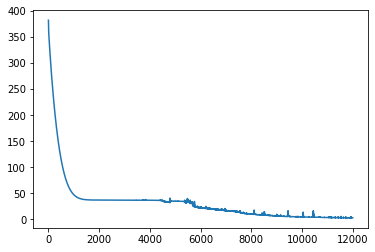

Train RMSE Loss: 1.6129455217076316
Test Prediction (on unknown locations)
true
tensor([ 61.7857,  70.3842,  30.5000,  53.1379,  69.3333,  25.0000,  59.8614,
         55.4595,  38.7273,  90.6923,  89.5128,  73.2783,  58.6000,  60.0750,
         58.3158,  78.8421, 102.4237, 103.8000,  62.9837,  65.5143,  67.0000,
         97.0952,  75.2000,  77.7143,  86.9444, 117.2891, 106.3103,  39.0000,
         60.2200,  60.7500,  75.9286,  65.2556,  47.2222], device='cuda:0')
predicted
tensor([ 67.9248,  66.4987,  28.5981,  57.1511,  61.6999,  29.8809,  80.2730,
         76.4499,  35.7642,  89.2213,  66.9367,  65.0932,  73.5854,  52.0253,
         62.0166,  72.4487,  64.7916,  89.8274,  68.1575,  68.3241,  44.1067,
        121.8446,  63.7977,  58.3791,  77.8562,  55.6533, 130.4950,  25.6783,
         97.7830,  71.0170,  71.6801,  59.3873,  50.8452], device='cuda:0',
       grad_fn=<IndexBackward>)
Test RMSE Loss : 18.63190593313448

Analysing Interpolation (on both known and unknown locations)
True

In [4]:
if window_method: sliding_window()
else:
    normal_train()

In [5]:
# normal train in a loop of hidden dim from 7 to 15 -> only used for hyperparameter tuning, not real training
def normal_train_loop():
    indices = torch.nonzero(mask, as_tuple=True)
    known_locations = len(indices[0])
    test_indices1 = random.sample(range(known_locations), int(known_locations * test_fraction))
    test_indices = [None for _ in range(len(indices))]
    for i in range(len(indices)):
        test_indices[i] = indices[i][test_indices1]
    test_indices = tuple(test_indices)
    mask[test_indices] = 0
    # now just need to get indices and make combined_grid to zero at those places.
    for i in range(time_steps):
        combined_grid[0][i][0][test_indices] = 0

    train_data = combined_grid
    train_labels = combined_aqi
    # Combined grid is created only once.
    # move to cuda
    train_data = train_data.to(device)
    train_labels = train_labels.to(device)
    l = []
    for epochs in range(10000,18000,1000):
        temp_h = []
        for h in range(7,17):
            model = convLSTM_interpolation.Model((grid_size, grid_size),len(features),h)
            model = model.to(device)
            opt = torch.optim.Adam(model.parameters(),lr=learning_rate)
            loss_arr = []
            for i in range(epochs):
                loss_value, output = train(opt,model,train_data,train_labels)
                loss_arr.append(loss_value)
        #         if i % 20==0: print(f"{i}: {loss_arr[i]}")#\n{output[0][0][0]}")

#             fig0 = plt.figure(0)temp_h
#             plt.plot([i for i in range(epochs)],loss_arr,label='Loss')
    #         plt.savefig('loss.png')
#             plt.show()
            train_rmse = np.sqrt(loss_arr[epochs-1])
            test_rmse = np.sqrt(eval(train_data,train_labels,model,test_indices))
            print(f"Hidden Dimension : {h}, epochs: {epochs}, Train RMSE Loss : {train_rmse}, Test RMSE Loss : {test_rmse}")
            temp_h.append((epochs,h,train_rmse,test_rmse))
        l.append(temp_h)
    
    print(l)
    
    return l

In [6]:
# normal_train_loop()